In [4]:
import numpy as np
from scipy.signal import correlate2d

In [5]:
import matplotlib.pyplot as plt
def plot_ca(array, rows, cols):
    cmap = plt.get_cmap('Blues')
    plt.imshow(array, cmap=cmap, interpolation='none')

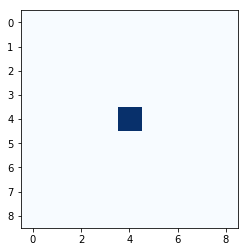

In [6]:
kernel = np.array([[0,1,0], [1,-4,1], [0, 1, 0]])
array =  np.zeros((9, 9), dtype=np.float64)
array[4,4] = 1
c = correlate2d(array, kernel, mode='same')
plot_ca(array, 5, 5)

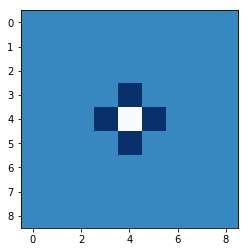

In [7]:
r = 0.1
for i in range(0, 5):
    array += r * c

plot_ca(array, 5, 5)

In [10]:
def add_island(a, height=0.1):
    n, m = a.shape
    radius = min(n, m)
    i = n//2
    j = m//2
    a[i-radius:i+radius, j-radius:j+radius] = height

class ReactionDiffusion:
    kernel = np.array([[.05, .2, .05],
                       [ .2, -1, .2],
                       [.05, .2, .05]])
    
    def __init__(self, n, m, params, noise=0.1):
        self.params = params
        self.array1 = np.ones((n, m), dtype=float)
        self.array2 = noise * np.random.random((n, m))
        add_island(self.array2)
        
    def step(self):
        A = self.array1
        B = self.array2
        ra, rb, f, k = self.params
        options = dict(mode='same', boundary='wrap')

        cA = correlate2d(A, kernel, **options)
        cB = correlate2d(B, kernel, **options)
        
        reaction = A * B**2
        self.array1 += ra * cA - reaction + f * (1-A)
        self.array2 += rb * cB + reaction - (f+k) * B

    def draw(self):
        plot_ca(self.array1, None, None)
        plot_ca(self.array2, None, None)

In [11]:
r = ReactionDiffusion(5, 5, {})

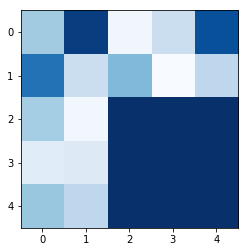

In [12]:
r.draw()

In [29]:
class Percolation:
    kernel = np.array([[0, 1, 0],
                       [1, 0, 1],
                       [0, 1, 0]])
    
    def __init__(self, n, q):
        self.q = q
        self.array = np.random.choice([1, 0], (n, n), p=[q, 1-q])
        self.array[0] = 5
        
    def step(self):
        a = self.array
        c = correlate2d(a, self.kernel, mode='same')
        self.array[(a==1) & (c>=5)] = 5
        
    def num_wet(self):
        """Total number of wet cells."""
        return np.sum(self.array == 5)
    
    def bottom_row_wet(self):
        """Number of wet cells in the bottom row."""
        return np.sum(self.array[-1] == 5)
        

In [30]:
def test_perc(perc):
    num_wet = perc.num_wet()
    
    while True:
        perc.step()
        
        if perc.bottom_row_wet():
            return True
        
        new_num_wet = perc.num_wet()
        if new_num_wet == num_wet:
            return False
        
        num_wet = new_num_wet

In [33]:
def estimate_prob_percolating(n=100, q=0.6, iters=100):
    t = [test_perc(Percolation(n, q)) for i in range(iters)]
    return np.mean(t)

In [34]:
print(estimate_prob_percolating())

0.61


In [35]:
def find_critical(n=100, q=0.6, iters=100):
    qs = [q]
    for i in range(iters):
        perc = Percolation(n, q)
        if test_perc(perc):
            q -=0.005
        else:
            q += 0.005
        qs.append(q)
    return qs

In [36]:
print(find_critical())

[0.6, 0.595, 0.59, 0.585, 0.59, 0.595, 0.59, 0.595, 0.59, 0.585, 0.58, 0.585, 0.58, 0.585, 0.59, 0.595, 0.59, 0.585, 0.59, 0.585, 0.58, 0.585, 0.59, 0.595, 0.6, 0.595, 0.6, 0.595, 0.59, 0.595, 0.59, 0.585, 0.58, 0.585, 0.59, 0.595, 0.6, 0.605, 0.6, 0.595, 0.6, 0.595, 0.59, 0.595, 0.59, 0.595, 0.6, 0.595, 0.59, 0.585, 0.58, 0.585, 0.58, 0.575, 0.57, 0.575, 0.58, 0.585, 0.59, 0.595, 0.6, 0.595, 0.6, 0.595, 0.59, 0.595, 0.59, 0.595, 0.6, 0.595, 0.59, 0.585, 0.59, 0.595, 0.59, 0.595, 0.6, 0.595, 0.6, 0.595, 0.59, 0.585, 0.59, 0.585, 0.59, 0.585, 0.59, 0.585, 0.58, 0.585, 0.59, 0.595, 0.59, 0.595, 0.6, 0.595, 0.59, 0.585, 0.59, 0.595, 0.59]


In [37]:
def make_table(rule):
    rule = np.array([rule], dtype=np.uint8)
    table = np.unpackbits(rule)[::-1]
    return table
    
class Cell1D:
    def __init__(self, rule, n, m=None):
        self.table = make_table(rule)
        self.n = n
        self.m = 2*n + 1 if m is None else m
        self.array = np.zeros((n, self.m), dtype=np.int8)
        self.next = 0
        
    def start_single(self):
        self.array[0, self.m//2] = 1
        self.next += 1
    
    def step(self):
        """Executes one time step by computing the next row of the array."""
        a = self.array
        i = self.next
        window = [4, 2, 1]
        c = np.correlate(a[i-1], window, mode='same')
        a[i] = self.table[c]
        self.next += 1

In [38]:
def count_cells(rule, n=500):
    ca = Cell1D(rule, n)
    ca.start_single()
    
    res = []
    for i in range(1, n):
        cells = np.sum(ca.array)
        res.append((i, i**2, cells))
        ca.step()
    return res

[(1, 1, 1),
 (2, 4, 3),
 (3, 9, 4),
 (4, 16, 6),
 (5, 25, 7),
 (6, 36, 9),
 (7, 49, 10),
 (8, 64, 12),
 (9, 81, 13),
 (10, 100, 15),
 (11, 121, 16),
 (12, 144, 18),
 (13, 169, 19),
 (14, 196, 21),
 (15, 225, 22),
 (16, 256, 24),
 (17, 289, 25),
 (18, 324, 27),
 (19, 361, 28),
 (20, 400, 30),
 (21, 441, 31),
 (22, 484, 33),
 (23, 529, 34),
 (24, 576, 36),
 (25, 625, 37),
 (26, 676, 39),
 (27, 729, 40),
 (28, 784, 42),
 (29, 841, 43),
 (30, 900, 45),
 (31, 961, 46),
 (32, 1024, 48),
 (33, 1089, 49),
 (34, 1156, 51),
 (35, 1225, 52),
 (36, 1296, 54),
 (37, 1369, 55),
 (38, 1444, 57),
 (39, 1521, 58),
 (40, 1600, 60),
 (41, 1681, 61),
 (42, 1764, 63),
 (43, 1849, 64),
 (44, 1936, 66),
 (45, 2025, 67),
 (46, 2116, 69),
 (47, 2209, 70),
 (48, 2304, 72),
 (49, 2401, 73),
 (50, 2500, 75),
 (51, 2601, 76),
 (52, 2704, 78),
 (53, 2809, 79),
 (54, 2916, 81),
 (55, 3025, 82),
 (56, 3136, 84),
 (57, 3249, 85),
 (58, 3364, 87),
 (59, 3481, 88),
 (60, 3600, 90),
 (61, 3721, 91),
 (62, 3844, 93),
 (63